# Complete Final Project

### Optional part (6)

To conclude our project, we built a final stereo matching algorithm joining together (in a proper way) all the parts of code that actually brought an improvement to the baseline algorithm, as resulting in an enhancement of the disparity map's quality. 

Specifically, the final algorithm should include Left-Right check, postfiltering and the rejection of ambiguous matches.

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [3]:
def open_img(img):
    image=cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    copied_image= np.copy(image)
    plt.imshow(copied_image, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
    return copied_image


#functions for SAD implementation
def AD_left(imgL, imgR, i, j, disp, m, n):
    S=np.abs(int(imgL[i+m, j+n])-int(imgR[i+m, j+n+disp]))
    
    return S

def AD_right(imgL, imgR, i, j, disp, m, n):
    S=np.abs(int(imgL[i+m, j+n-disp])-int(imgR[i+m, j+n]))
    
    return S


#function to calculate the mapping error, taking into account the invalid pixels
def Error2( target, img, w, h, m, scale_factor, v_pixel, d_max, ig_border):
    error=0
    for j in range(m+d_max, w-m-d_max-ig_border):
        for i in range(m, h-m-ig_border):
            if(img[i,j]!=255):
                if(abs(target[i, j]/scale_factor - img[i, j]/scale_factor)>1):
                    error=error+1
    
    return (error/v_pixel)

The following lines implement the loading of the various images the dataset provided. As a consequence, please gradually markdown the blocks in succession, in orther to work only with the disired image each time.

###### Map

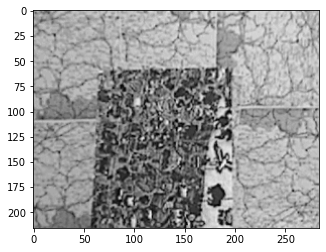

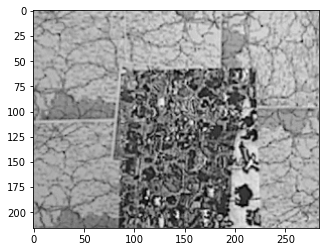

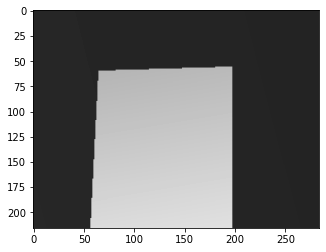

In [4]:
mapL= open_img("map/im1.pgm")
mapR= open_img("map/im0.pgm")
mapG= open_img("map/disp1.pgm")

#parameters
disp_min =0
disp_max =29
disp_scale =8
ignore_border =0

#image shape values
img_raw=mapL.shape[0]
img_column=mapL.shape[1]

imageL=mapL
imageR=mapR

###### Sawtooth

sawtoothL= open_img("sawtooth/im6.ppm")
sawtoothR= open_img("sawtooth/im2.ppm")
sawtoothG= open_img("sawtooth/disp6.pgm")

disp_min =0
disp_max =19
disp_scale= 8
ignore_border= 0

#image shape values
img_raw=sawtoothL.shape[0]
img_column=sawtoothL.shape[1]

imageL=sawtoothL
imageR=sawtoothR

###### Tsukuba

tsukubaL= open_img("tsukuba/scene1.row3.col3.ppm")
tsukubahR= open_img("tsukuba/scene1.row3.col2.ppm")
tsukubaG= open_img("tsukuba/truedisp.row3.col3.pgm")

disp_min =0
disp_max =15
disp_scale= 16
ignore_border= 18

#image shape values
img_raw=tsukubaL.shape[0]
img_column=tsukubaL.shape[1]

imageL=tsukubaL
imageR=tsukubahR

###### Venus

venusL= open_img("venus/im6.ppm")
venusR= open_img("venus/im2.ppm")
venusG= open_img("venus/disp6.pgm")

disp_min=0
disp_max =19
disp_scale= 8

ignore_border= 0

img_raw=venusL.shape[0]
img_column=venusL.shape[1]

imageL=venusL
imageR=venusR

## Bidirectional matching with SAD + Non global minimum rejection 

The supporting window'size is chosen. As we have explained in the report, we have tried multiple values, seeking for the better one that fits each image. According to our experimental results K=3 best fits Map and Sawtooth, while K=4 should be selected for Tsukuba and Venus.

In [5]:
#window shape
K=3

MapL=np.zeros((img_raw, img_column), dtype=np.uint8)
MapR=np.zeros((img_raw, img_column), dtype=np.uint8)
MapL2=np.zeros((img_raw, img_column), dtype=np.uint8)

The baseline algorithm is repeated twice. In particular, when the mapping is performed from right to left (reverse matching phase), the function is implemented in a specular way. Then, the disparity values (computed at a pixel within the disparity range) both for the left and right image are saved in two arrays, sorted in ascending order. For both maps, the match is considered valid if the difference of the first element of the vector (minimum) with the third one is greater than a certain threshold, set at 10%.

Left map


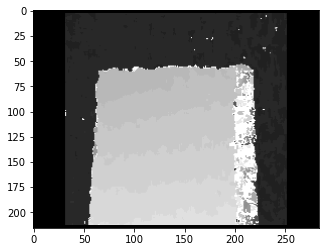

Right map


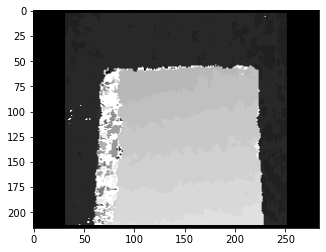

In [6]:
#in order to get every pixels' position in the image we compute two loops
#the indexes'values start from K 
#the indexes are increased until the maximum useful value minus K otherwise it overflows
disp_L=0
disp_R=0
for i in range(K, img_raw-K-ignore_border):
    for j in range(K+disp_max, img_column-K-ignore_border-disp_max): 
        #We select the pixel and move along its row
        min_SAD_L=500000
        min_SAD_R=500000
        x=0
        sad_array_L=np.zeros(disp_max+1-disp_min)
        y=0
        sad_array_R=np.zeros(disp_max+1-disp_min)
        #moving along the epipolar line
        for d in range(disp_min, disp_max+1):
            SAD_L=0
            SAD_R=0
            for m in range(-K, K+1): #m and n should span this range to be able to catch all the pixels starting from K  
                for n in range(-K, K+1):
                    #matching images both from left to right and from right to left
                    SAD_L =SAD_L+AD_left(imageL, imageR, i, j, d, m, n)
                    SAD_R =SAD_R+AD_right(imageL, imageR, i, j, d, m, n)
            
            #for each disparity value save the SADs obtained in two arrays
            sad_array_L[x]=SAD_L
            x=x+1
            
            sad_array_R[y]=SAD_R
            y=y+1
            
            if(SAD_L<=min_SAD_L):
                min_SAD_L=SAD_L
                disp_L=d
            if(SAD_R<=min_SAD_R):
                min_SAD_R=SAD_R
                disp_R=d
        #sort the arrays and mark the match as invalid (white) if the minimum is not sharp enough
        sad_array_L=np.sort(sad_array_L)
        
        if((sad_array_L[2]-sad_array_L[0])<0.1*sad_array_L[0]):
            disp_L=255/disp_scale
        
        sad_array_R=np.sort(sad_array_R)
        
        if((sad_array_R[2]-sad_array_R[0])<0.1*sad_array_R[0]):
            disp_R=255/disp_scale
        
        MapL[i,j]=np.asarray([disp_L*disp_scale])
        MapR[i,j]=np.asarray([disp_R*disp_scale])

print("Left map")
plt.imshow(MapL, cmap='gray', vmin=0, vmax=255)
plt.show()

print("Right map")
plt.imshow(MapR, cmap='gray', vmin=0, vmax=255)
plt.show()

## Left-Right cosistency check 

The comparison between the two disparity maps (MapL and MapR) is done as follows:
- a pixel (i,j) is selected from the right image (its disparity value is 𝑀𝑎𝑝𝑅[𝑖,𝑗])
-  then, its corresponding point in the left image is picked (it is found at position (i,j-𝑀𝑎𝑝𝑅[𝑖,𝑗]) and its disparity value is 𝑀𝑎𝑝𝐿[i,j-𝑀𝑎𝑝𝑅[𝑖,𝑗]])
- lastly, the matching point of the latter is taken at position (i, j-𝑀𝑎𝑝𝑅[𝑖,𝑗]+𝑀𝑎𝑝𝐿[i,j-𝑀𝑎𝑝𝑅[𝑖,𝑗]])

If  𝑀𝑎𝑝𝑅[𝑖,𝑗] ≠ 𝑀𝑎𝑝𝐿[𝑖,𝑗−𝑀𝑎𝑝𝑅[𝑖,𝑗]]  a projection error is present (i.e. the match is not coherent) as if we start on a point on the right image, move to its respective on the left one and jump back to the right image we do not reach the initial point.

Modified left map


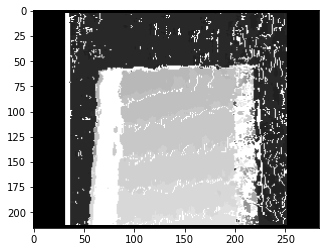

Percentage of the invalid matches in the image:  0.15733766233766233


In [7]:
valid_pixel=0
MapL2=np.copy(MapL)
for j in range(K+disp_max, img_column-K-disp_max-ignore_border):
    for i in range(K, img_raw-K-ignore_border):
            #select a pixel in the right side
            DR=MapR[i,j]/disp_scale
            #pick its counterpart in the left image
            DL=MapL[i,j-int(DR)]/disp_scale
            
            #check the consistency of the match 
            if(DL!=DR):
                MapL2[i,j]=np.asarray([255])
            else:
                valid_pixel= valid_pixel+1

print("Modified left map")
plt.imshow(MapL2, cmap='gray', vmin=0, vmax=255)
plt.show()

total_pixel=(img_column-ignore_border-2*disp_max-2*K)*(img_raw-ignore_border-2*K)
print("Percentage of the invalid matches in the image: ", 1-(valid_pixel/total_pixel))

## Postfiltering

Once the final disparity map is obtained, the Median filter is applied in order to cancel out possible remaining "spikes" and spurious errors.

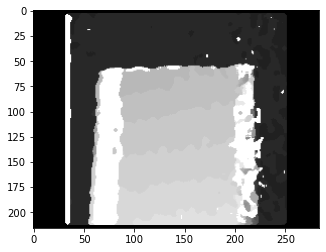

In [8]:
#post filter with median filter
k_size = 5
MapL2_filtered = cv2.medianBlur(MapL2,k_size)

plt.imshow(MapL2_filtered,cmap='gray',vmin=0,vmax=255)
plt.show()

Finally, the mapping error is calculated. As now not all the pixels feature a valid disparity value, the standard Error function has been modified in order to take that into account. The line of interest should be uncommented.

In [9]:
mapping_error=Error2(mapG,MapL2_filtered,img_column,img_raw,K, disp_scale, valid_pixel, disp_max, ignore_border)
#mapping_error=Error2(sawtoothG,MapL2_filtered,img_column,img_raw, K, disp_scale, valid_pixel, disp_max, ignore_border)
#mapping_error=Error2(tsukubaG,MapL2_filtered,img_column,img_raw,K, disp_scale, valid_pixel, disp_max, ignore_border)
#mapping_error=Error2(venusG,MapL2_filtered,img_column,img_raw, K, disp_scale, valid_pixel, disp_max, ignore_border)

print("the final mapping error is:\n", mapping_error)

the final mapping error is:
 0.05484061544784362


If desired, the obtained disparity map could be saved uncommenting and executing the following code.

In [10]:
#cv2.imwrite("complete_map.png", MapL2_filtered)
#cv2.imwrite("complete_sawtooth.png", MapL2_filtered)
#cv2.imwrite("complete_tsukuba.png", MapL2_filtered)
#cv2.imwrite("complete_venus.png", MapL2_filtered)